# Quantifying National Forest Accessibility

Quantifying accessibility to National Forest hiking trails based on travel time is an essential part of understanding the public benefit provided by NFS. The accessibility zone refers to the geographic area from which people can reach a particular site, such as a hiking trail, within a given travel time.

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, LineString, box
import osmnx as ox
import networkx as nx
import folium
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='osmnx')

1. Prepare Input Data

We start with a map of the National Forest system in Region 8 (U.S. South). We will eventually be interested in access to old growth access, so we will also want to include observations of old growth forest from the FIA's National Forest Inventory.

Let's use the administrative boundaries from the FS geospatial gateway. 

https://data.fs.usda.gov/geodata/edw/datasets.php

Old growth observations were obtained from FIA datamart

https://research.fs.usda.gov/products/dataandtools/tools/fia-datamart

Old growth forest is defined in this report:

https://www.fs.usda.gov/sites/default/files/fs_media/fs_document/Mature-and-Old-Growth-Forests.pdf

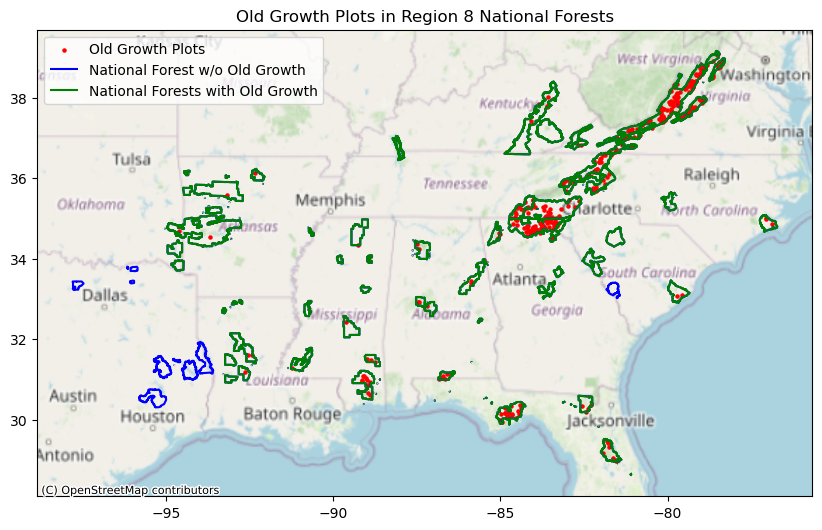

In [5]:
file_path = '/Users/mihiarc/Work/data/'

# load national forest boundaries
forest_boundary = gpd.read_file(file_path + 'spatial-boundaries/nfs-layers/FS Admin Boundaries/S_USA.AdministrativeForest.shp')
forest_boundary_region_8 = forest_boundary[forest_boundary['REGION'] == '08']
# drop El Yunque National Forest, PR
forest_boundary_region_8 = forest_boundary_region_8[forest_boundary_region_8['FORESTNAME'] != 'El Yunque National Forest']
# Load the forest plot data
forest_df = pd.read_csv(file_path + 'MOG_FIA-selected/FIA_2023_PLOT_US_MOG.csv')

# old growth only
# Filter data with specific criteria
forest_df = forest_df[
    (forest_df['LOCATION_NM'].isin(['Alabama', 'North Carolina', 'South Carolina',
                                    'Texas', 'Florida', 'Tennessee', 'Virginia',
                                    'Kentucky', 'Georgia', 'Mississippi',
                                    'Louisiana', 'Arkansas', 'Oklahoma'])) &
    (forest_df['MOG_LABEL'] == 'Old growth') &
    (forest_df['OWNGRPCD'] == 10)
]

# Create a GeoDataFrame with geometry from latitude and longitude
forest_gdf = gpd.GeoDataFrame(
    forest_df,
    geometry=gpd.points_from_xy(forest_df['LON'], forest_df['LAT']),
    crs='EPSG:4326'
)

# select only the national forests that contain points in forest_gdf
forest_boundary_mog = forest_boundary[forest_boundary.intersects(forest_gdf.unary_union)]
fig, ax = plt.subplots(figsize=(10, 10))
forest_gdf.plot(ax=ax, color='red', markersize=5)
forest_boundary_region_8.boundary.plot(ax=ax, color='blue')
forest_boundary_mog.boundary.plot(ax=ax, color='green')
# Add basemap
ctx.add_basemap(ax, crs=forest_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)
# add legend
plt.legend(['Old Growth Plots', 'National Forest w/o Old Growth', 'National Forests with Old Growth'])
plt.title('Old Growth Plots in Region 8 National Forests')
plt.show()

2. Define the access points
   
Next, we load and clean the Hiking Trail data that we also obtained from the Forest Service's geospatial gateway. We want to focus on hiking trails in Region 8 that are no more than 5 miles long and allow for walking. 

Once cleaned, we can use the folium library to create an interactive map.

In [ ]:
import os

# load NF trails
file_path = '/Users/mihiarc/Work/data/'
shapefile = os.path.join(file_path, 'spatial-boundaries', 'nfs-layers', 'FS Hiking Trails', 'S_USA.TrailNFS_Publish.shp')
try:
    nfs_trails = gpd.read_file(shapefile)
except FileNotFoundError:
    print("Shapefile not found. Please check the file path.")
    raise

# clip to the region 8 boundary
nfs_trails = gpd.clip(nfs_trails, forest_boundary_region_8)

# select desired variables
nfs_trails_filtered = nfs_trails[['ADMIN_ORG', 'TRAIL_CN', 'TRAIL_NAME', 'TRAIL_NO', 'TRAIL_TYPE',
                         'BMP', 'EMP', 'SEGMENT_LE', 'GIS_MILES', 'SHAPE_LEN', 'geometry']].copy()

# create new columns for region, forest, and ranger district
# ADMIN_ORG format: '080101' where each code is two digits
nfs_trails_filtered['REGION'] = nfs_trails_filtered['ADMIN_ORG'].str[:2]
nfs_trails_filtered['FOREST'] = nfs_trails_filtered['ADMIN_ORG'].str[2:4]
nfs_trails_filtered['RANGER_DISTRICT'] = nfs_trails_filtered['ADMIN_ORG'].str[4:]

# filter trails in region 8, TERRA trail type, and GIS_MILES <= 5
REGION_CODE = '08'
MAX_TRAIL_LENGTH = 5
MAP_CENTER = [34.5, -84]
MAP_ZOOM = 5

filtered_trails = nfs_trails_filtered[
    (nfs_trails_filtered['REGION'] == REGION_CODE) &
    (nfs_trails_filtered['TRAIL_TYPE'] == 'TERRA') &
    (nfs_trails_filtered['GIS_MILES'] <= MAX_TRAIL_LENGTH)
].copy()

# Group by 'TRAIL_NO' and get the index of the minimum 'GIS_MILES' for each group
min_gis_miles_idx = filtered_trails.groupby('TRAIL_NO')['GIS_MILES'].idxmin()

# Use the indices to filter
nfs_trails_region_8_terra_min_gis_miles = filtered_trails.loc[min_gis_miles_idx]

# repeat filtering using 'TRAIL_NAME' 
# Group by 'TRAIL_NAME' and get the index of the minimum 'GIS_MILES' for each group
min_gis_miles_idx = filtered_trails.groupby('TRAIL_NAME')['GIS_MILES'].idxmin()

# Use the indices to filter
filtered_trails = filtered_trails.loc[min_gis_miles_idx]
# drop if missing geometry
filtered_trails = filtered_trails.dropna(subset=['geometry'])
# drop rows with multilinestring geometries
filtered_trails = filtered_trails[
    filtered_trails['geometry'].apply(lambda x: x.geom_type) == 'LineString'
]
# Function to extract the starting point of a trail
def get_starting_point(geometry):
    if geometry.geom_type == 'LineString':
        return geometry.coords[0]
    else:
        return None

# Apply the function to create a new column with the starting point
filtered_trails['starting_point'] = filtered_trails['geometry'].apply(get_starting_point)

# Display the DataFrame with the new column
filtered_trails[['TRAIL_NAME', 'starting_point']]
# make a copy called 'trail_starts' and convert 'starting_point' to a Point object
trail_starts = filtered_trails.copy()

# save trail_starts to a GeoDataFrame



In [4]:
# use folium to plot the trail starting points
import folium
from folium.plugins import MarkerCluster

# Create a folium map centered on Region 8
m = folium.Map(location=MAP_CENTER, zoom_start=MAP_ZOOM)

# Add a marker cluster to the map
marker_cluster = MarkerCluster().add_to(m)

# Add markers for the trail starting points
for idx, row in trail_starts.iterrows():
    coords = row['starting_point']
    if coords is not None:
        folium.Marker(location=[coords[1], coords[0]], popup=row['TRAIL_NAME']).add_to(marker_cluster)

# Display the map
m
# Save the folium map to an HTML file
# m.save('region8_trail_map.html')

3. Create isochrone for a test trail

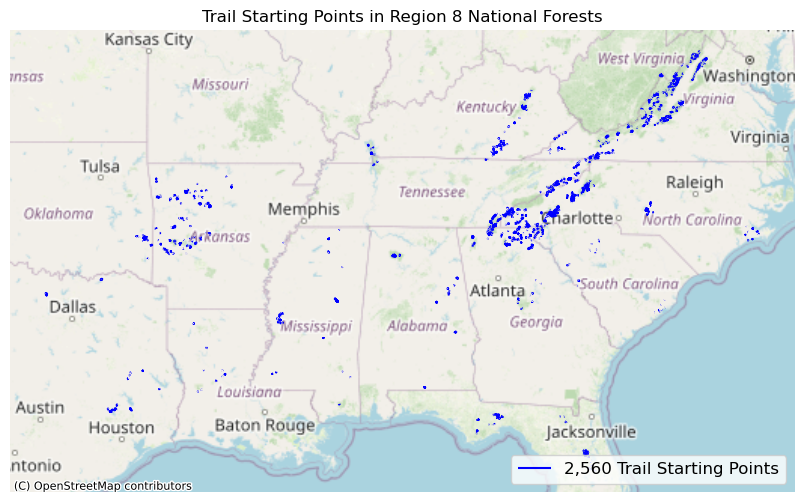

In [ ]:
# convert to projected crs
trail_starts_projected = trail_starts.to_crs(epsg=3857)
# plot the trails on a static map
fig, ax = plt.subplots(figsize=(12, 6))
# set the legend symbol to a circle
trail_starts_projected.plot(ax=ax, color='blue', markersize=5, legend=True)
ctx.add_basemap(ax, crs=trail_starts_projected.crs, source=ctx.providers.OpenStreetMap.Mapnik)
# add legend
n_trails = trail_starts.shape[0]
# use legend to display the number of trail starting points
plt.legend([f'{n_trails:,} Trail Starting Points'], loc='lower right', fontsize='large')
plt.title('Trail Starting Points in Region 8 National Forests')
# remove axis
plt.axis('off')
plt.show()


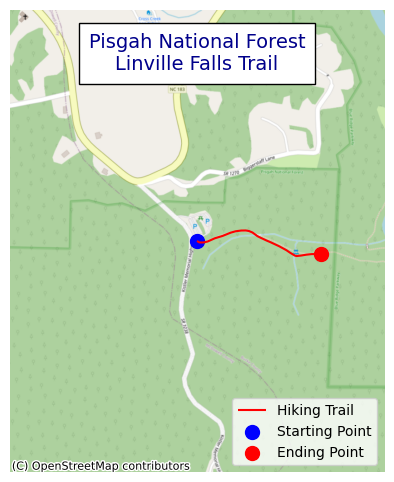

In [140]:
# test on a specific trail
trail_name = 'LINVILLE FALLS'

# Filter the trail_starts GeoDataFrame for the trail
current_trail = trail_starts[trail_starts['TRAIL_NAME'] == trail_name]
# set the crs for use in open street map
current_trail.crs = 'EPSG:4326'

starting_point = current_trail.iloc[0]['starting_point']

# Plot the trail on a basemap
fig, ax = plt.subplots(figsize=(12, 6))
current_trail.plot(ax=ax, color='red', markersize=50, label='Hiking Trail')
# Convert the starting point to a GeoSeries
starting_point_gs = gpd.GeoSeries([Point(starting_point)], crs=current_trail.crs)
starting_point_gs.plot(ax=ax, color='blue', markersize=100, label='Starting Point')
# add ending point
ending_point = current_trail.iloc[0]['geometry'].coords[-1]
ending_point_gs = gpd.GeoSeries([Point(ending_point)], crs=current_trail.crs)
ending_point_gs.plot(ax=ax, color='red', markersize=100, label='Ending Point')

# set map zoom
ax.set_xlim([starting_point[0] - 0.005, starting_point[0] + 0.005])
ax.set_ylim([starting_point[1] - 0.005, starting_point[1] + 0.005])
# Add basemap for context
ctx.add_basemap(ax, crs=current_trail.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Add a title on the map
ax.text(
    0.5, 0.95,  # Coordinates in axis fraction (0.5 is center, 0.95 is near the top)
    'Pisgah National Forest\nLinville Falls Trail',  # Title text
    fontsize=14,
    color='darkblue',
    ha='center',  # Horizontal alignment
    va='top',  # Vertical alignment
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'),  # Optional: Add background
    transform=ax.transAxes  # Use axis fraction for positioning
)

plt.axis('off')
plt.legend(loc='lower right')
plt.show()

In [14]:
# setup the trail head coordinates
trail_head_coords = (starting_point[1], starting_point[0])

# Define your travel time limit in minutes
travel_time_limit = 45
average_speed_mph = 60
average_speed_kmh = average_speed_mph * 1.60934  # Convert to km/h
average_speed_ms = average_speed_kmh * (1000 / 3600)  # Convert to m/s
dist = average_speed_ms * travel_time_limit * 60  # Calculate distance

G = ox.graph_from_point(trail_head_coords, network_type='drive', dist=dist)

# Add edge speeds and travel times
ox.routing.add_edge_speeds(G)
ox.routing.add_edge_travel_times(G)

# Get the nearest node to the trail head location in the graph
trail_head_node = ox.nearest_nodes(
        G, X=starting_point_gs.geometry.x.iloc[0], Y=starting_point_gs.geometry.y.iloc[0]
    )

# Convert travel time limit to seconds
travel_time_limit_sec = travel_time_limit * 60

# Find nodes reachable within the travel time limit
subgraph = nx.ego_graph(
        G, trail_head_node, radius=travel_time_limit_sec, distance='travel_time'
    )

# Extract the geometries of the nodes in the subgraph
node_points = [
        Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)
    ]

# Create a GeoDataFrame of the nodes
nodes_gdf = gpd.GeoDataFrame(geometry=node_points, crs=G.graph['crs'])

# Create an isochrone polygon (convex hull)
isochrone = nodes_gdf.unary_union.convex_hull

# Convert the road network to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

# Filter the edges that intersect with the isochrone polygon
roads_in_isochrone = edges[edges.intersects(isochrone)]
roads_in_isochrone = roads_in_isochrone.simplify(tolerance=10)


/opt/anaconda3/envs/geo/lib/python3.9/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


/opt/anaconda3/envs/geo/lib/python3.9/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/var/folders/c9/dwfk30c575n0dw3tkq6prd940000gn/T/ipykernel_67629/1336885472.py:47: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower right', fontsize='large')


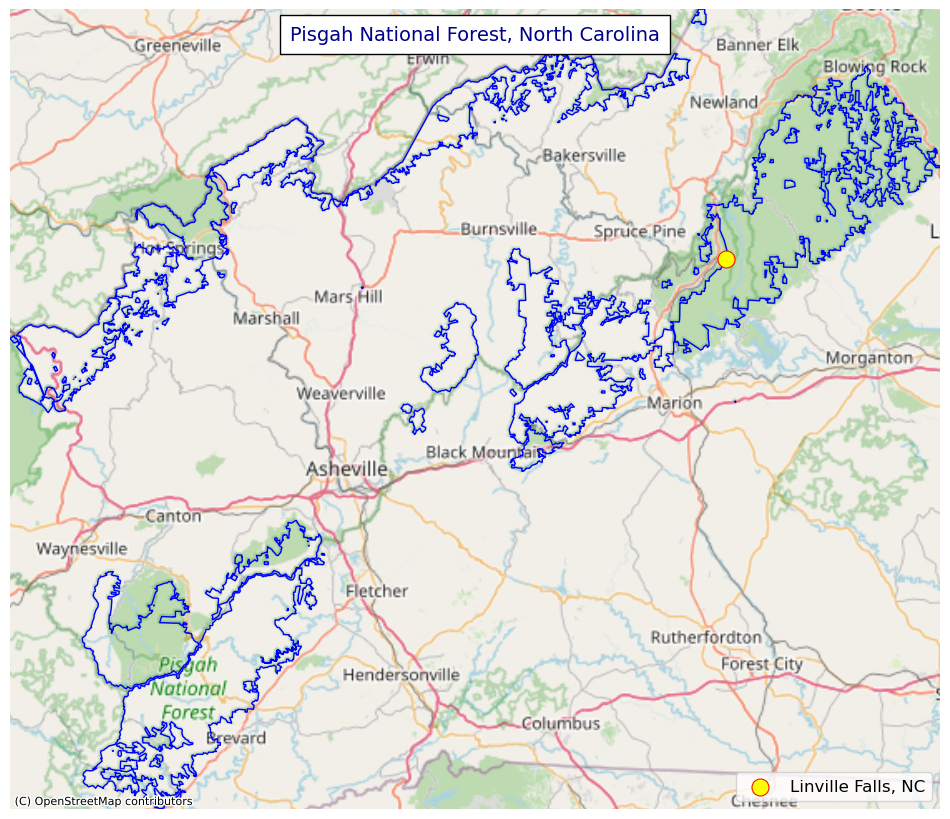

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox

# Define the area of interest
place_name = "Pisgah National Forest, North Carolina, USA"

# Get the boundary polygon as a GeoDataFrame
pisgah_polygon = ox.geocode_to_gdf(place_name)

# Convert the polygon's CRS to EPSG:3857 (Web Mercator)
pisgah_polygon = pisgah_polygon.to_crs(epsg=3857)

point_trail_head = (-81.9260, 35.8783)
trail_head = gpd.GeoSeries([Point(point_trail_head)], crs='EPSG:4326').to_crs(pisgah_polygon.crs)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the boundary polygon
pisgah_polygon.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)

# Plot the trail head
trail_head.plot(ax=ax, color='yellow', markersize=150, edgecolor='red', linewidth=0.75, label='Linville Falls, NC')

# Set limits to the polygon's extent
ax.set_xlim(pisgah_polygon.total_bounds[[0, 2]])
ax.set_ylim(pisgah_polygon.total_bounds[[1, 3]])

# Add the basemap
ctx.add_basemap(ax, crs=pisgah_polygon.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Add a title on the map
ax.text(
    0.5, 0.98,  # Coordinates in axis fraction (0.5 is center, 0.95 is near the top)
    'Pisgah National Forest, North Carolina',  # Title text
    fontsize=14,
    color='darkblue',
    ha='center',  # Horizontal alignment
    va='top',  # Vertical alignment
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'),  # Optional: Add background
    transform=ax.transAxes  # Use axis fraction for positioning
)

ax.axis('off')
plt.legend(loc='lower right', fontsize='large')
# Show the plot
plt.show()

/var/folders/c9/dwfk30c575n0dw3tkq6prd940000gn/T/ipykernel_67629/3263972979.py:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower right', fontsize='large')


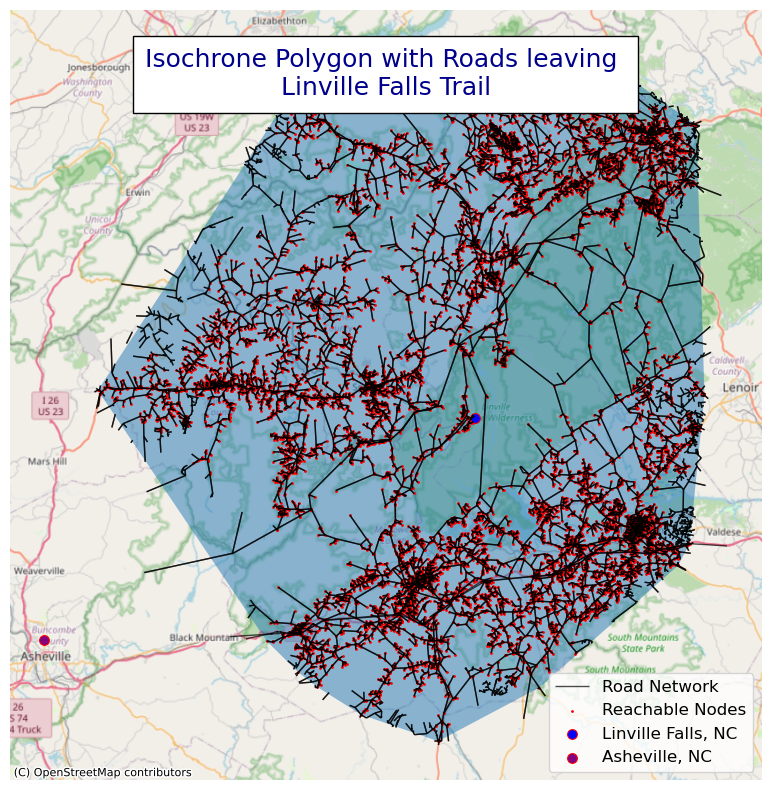

In [ ]:

# Improved plot for isochrone visualization with filtered roads
fig, ax = plt.subplots(figsize=(10, 10))

point_asheville = (-82.5540, 35.5951 + 0.02)
point_hickory_nc = (-81.3446, 35.7345 + 0.02)
point_boone_nc = (-81.6746, 36.2168 + 0.02)
point_trail_head = (-81.9260, 35.8783)

# Plot specific points with distinct markers
trail_head = gpd.GeoSeries([Point(point_trail_head)], crs='EPSG:4326').to_crs(G.graph['crs'])
asheville = gpd.GeoSeries([Point(point_asheville)], crs='EPSG:4326').to_crs(G.graph['crs'])
boone = gpd.GeoSeries([Point(point_boone_nc)], crs='EPSG:4326').to_crs(G.graph['crs'])

# Plot the isochrone polygon
gpd.GeoSeries([isochrone]).plot(ax=ax, alpha=0.5, label='Isochrone Polygon')

# Plot roads within the isochrone
roads_in_isochrone.plot(ax=ax, color='black', linewidth=1, alpha=0.7, label='Road Network')
# Plot the reachable nodes
nodes_gdf.plot(ax=ax, color='red', markersize=1, label='Reachable Nodes')
trail_head.plot(ax=ax, color='blue', markersize=50, edgecolor='red', linewidth=0.75, label='Linville Falls, NC')
asheville.plot(ax=ax, color='purple', markersize=50, edgecolor='red', linewidth=0.75, label='Asheville, NC')
# boone.plot(ax=ax, color='yellow', markersize=50, edgecolor='red', linewidth=0.75, label='Boone, NC')

# Add basemap
ctx.add_basemap(ax, crs=nodes_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Add legend
plt.legend(loc='lower right', fontsize='large')

# Add a title on the map
ax.text(
    0.5, 0.95,  # Coordinates in axis fraction (0.5 is center, 0.95 is near the top)
    'Isochrone Polygon with Roads leaving \nLinville Falls Trail',  # Title text
    fontsize=18,
    color='darkblue',
    ha='center',  # Horizontal alignment
    va='top',  # Vertical alignment
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'),  # Optional: Add background
    transform=ax.transAxes  # Use axis fraction for positioning
)

plt.axis('off')

# Show the plot
plt.show()

4. Characterize the communities with access

In [31]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv

# Load environment variables from .env file (if using)
load_dotenv()

# Replace with your actual Census API key
API_KEY = os.getenv('CENSUS_API_KEY')  # Ensure 'CENSUS_API_KEY' is set in your environment

if not API_KEY:
    raise ValueError("Census API key not found. Please set the 'CENSUS_API_KEY' environment variable.")

# Define the API endpoint
year = 2021  # ACS 5-Year Estimates year
dataset = 'acs/acs5'
base_url = f'https://api.census.gov/data/{year}/{dataset}'

# Define the variables to retrieve
variables = ['B01003_001E', 'NAME']  # Total population and Block Group name

# Define the geography: all Block Groups in NC
# Block Group identifiers require specifying state, county, and tract
# 'for=block group:*' specifies all block groups
# 'in=state:37 county:* tract:*' limits to all NC block groups across all tracts
params = {
    'get': ','.join(variables),
    'for': 'block group:*',
    'in': 'state:37 county:* tract:*',
    'key': API_KEY
}

# Make the API request
response = requests.get(base_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    
    # Convert to DataFrame
    df = pd.DataFrame(data[1:], columns=data[0])
    
    # Rename columns for clarity
    df.rename(columns={
        'B01003_001E': 'Population',
        'NAME': 'Block_Group_Name',
        'state': 'State_FIPS',
        'county': 'County_FIPS',
        'tract': 'Tract_Code',
        'block group': 'Block_Group_Number'
    }, inplace=True)
    
    # Convert Population to numeric, handle missing or non-numeric data
    df['Population'] = pd.to_numeric(df['Population'], errors='coerce')
    
    # Optionally, create a unique identifier for each Block Group
    df['Block_Group_ID'] = df['State_FIPS'] + df['County_FIPS'] + df['Tract_Code'] + df['Block_Group_Number']
    
    # Display the first few rows
    print(df.head())
    
    # Save to CSV
    df.to_csv('nc_block_groups_population.csv', index=False)
else:
    print(f"Error: {response.status_code}")
    print(response.text)

   Population                                   Block_Group_Name State_FIPS  \
0        1385  Block Group 1, Census Tract 201, Alamance Coun...         37   
1        1347  Block Group 2, Census Tract 201, Alamance Coun...         37   
2         973  Block Group 3, Census Tract 201, Alamance Coun...         37   
3         519  Block Group 4, Census Tract 201, Alamance Coun...         37   
4         750  Block Group 1, Census Tract 202, Alamance Coun...         37   

  County_FIPS Tract_Code Block_Group_Number Block_Group_ID  
0         001     020100                  1   370010201001  
1         001     020100                  2   370010201002  
2         001     020100                  3   370010201003  
3         001     020100                  4   370010201004  
4         001     020200                  1   370010202001  


In [32]:
# load census block group boundaries
file_path = '/Users/mihiarc/Work/data/'
block_groups = gpd.read_file(file_path + 'spatial-boundaries/cb_2023_us_bg_500k/cb_2023_us_bg_500k.shp')

# filter block groups in North Carolina
nc_block_groups = block_groups[block_groups['STATEFP'] == '37']

# merge the population data with the block group geometries
nc_block_groups = nc_block_groups.merge(df, left_on='GEOID', right_on='Block_Group_ID')

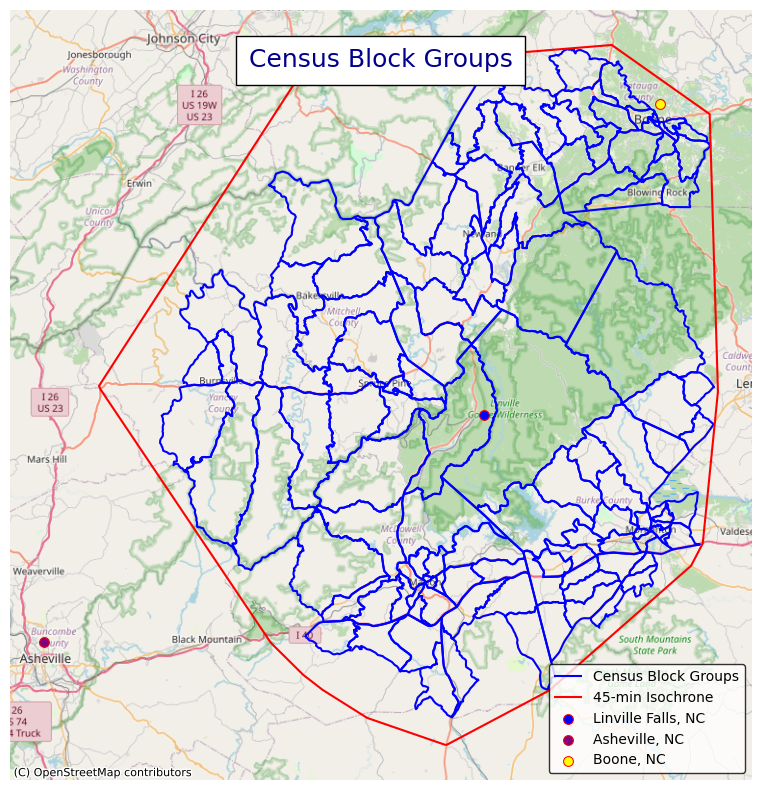

In [126]:
import geopandas as gpd
from shapely.ops import transform
from pyproj import Transformer
import matplotlib.pyplot as plt
import contextily as ctx

# Reproject nc_block_groups to EPSG:3857
nc_block_groups = nc_block_groups.to_crs(epsg=3857)

# Reproject isochrone to EPSG:3857
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
isochrone_proj = transform(transformer.transform, isochrone)

# Filter block groups within the isochrone polygon
block_groups_isochrone = nc_block_groups[nc_block_groups.within(isochrone_proj)]

# Create a GeoDataFrame with the isochrone polygon
isochrone_gdf = gpd.GeoDataFrame(geometry=[isochrone_proj], crs=nc_block_groups.crs)

# Reproject trail_head, asheville, and boone to EPSG:3857
trail_head = trail_head.to_crs(epsg=3857)
asheville = asheville.to_crs(epsg=3857)
boone = boone.to_crs(epsg=3857)

# Plot the block groups and isochrone
fig, ax = plt.subplots(figsize=(10, 10))
block_groups_isochrone.boundary.plot(ax=ax, color='blue', label='Census Block Groups')
isochrone_gdf.boundary.plot(ax=ax, color='red', label='45-min Isochrone')

# Plot the points with appropriate markers and sizes
trail_head.plot(ax=ax, color='blue', markersize=50, edgecolor='red', linewidth=0.75, label='Linville Falls, NC')
asheville.plot(ax=ax, color='purple', markersize=50, edgecolor='red', linewidth=0.75, label='Asheville, NC')
boone.plot(ax=ax, color='yellow', markersize=50, edgecolor='red', linewidth=0.75, label='Boone, NC')

# Add a title on the map
ax.text(
    0.5, 0.95,  # Coordinates in axis fraction (0.5 is center, 0.95 is near the top)
    'Census Block Groups',  # Title text
    fontsize=18,
    color='darkblue',
    ha='center',  # Horizontal alignment
    va='top',  # Vertical alignment
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'),  # Optional: Add background
    transform=ax.transAxes  # Use axis fraction for positioning
)

# Add the basemap
ctx.add_basemap(ax, crs=nc_block_groups.crs, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.legend(loc='lower right', facecolor='white', edgecolor='black')
plt.show()

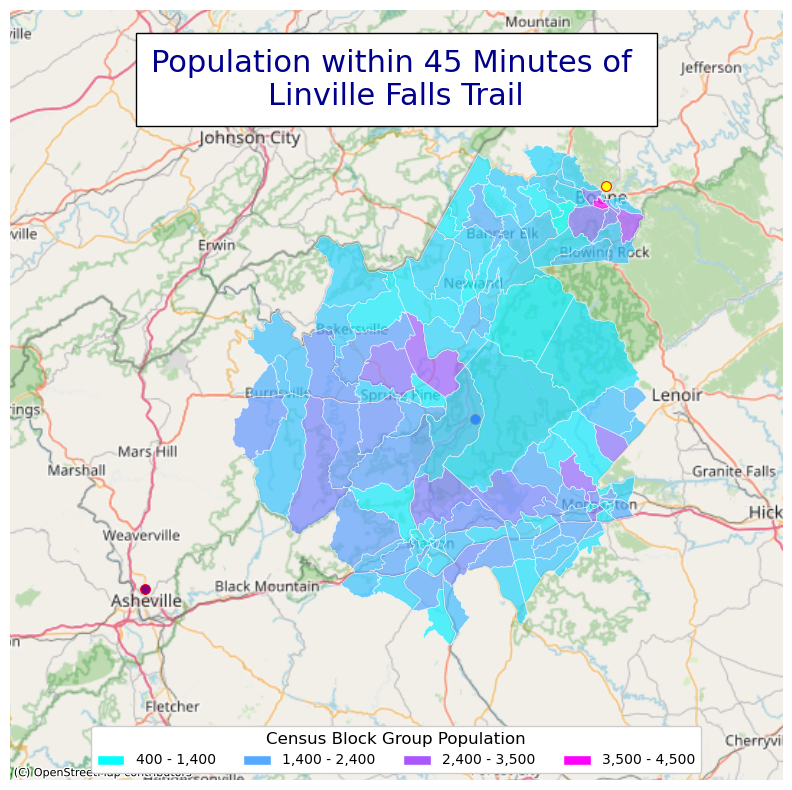

In [124]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # For adding a basemap
from matplotlib.colors import BoundaryNorm
import numpy as np
from matplotlib.patches import Patch

# Reproject the GeoDataFrame
block_groups_isochrone = block_groups_isochrone.to_crs(epsg=3857)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# add markers for trail head and cities
trail_head.plot(ax=ax, color='blue', markersize=50, edgecolor='red', linewidth=0.75, label='Linville Falls, NC')
asheville.plot(ax=ax, color='purple', markersize=50, edgecolor='red', linewidth=0.75, label='Asheville, NC')
boone.plot(ax=ax, color='yellow', markersize=50, edgecolor='red', linewidth=0.75, label='Boone, NC')

# Plot the block groups, using population data for choropleth
cmap = 'cool'  # colormap
block_groups_isochrone.plot(
    column='Population',
    cmap=cmap,
    linewidth=0.5,
    edgecolor='white',
    legend=False,  # We'll add a custom legend
    alpha=0.7,     # Adjust transparency
    ax=ax
)

# Zoom out by adjusting the extent
xlim = ax.get_xlim()
ylim = ax.get_ylim()
x_margin = (xlim[1] - xlim[0]) * 0.2  # 20% margin
y_margin = (ylim[1] - ylim[0]) * 0.2  # 20% margin
ax.set_xlim(xlim[0] - x_margin, xlim[1] + x_margin)
ax.set_ylim(ylim[0] - y_margin, ylim[1] + y_margin)

# Create a union of the block group geometries
trail_union = block_groups_isochrone.unary_union

# Create a custom legend
min_pop = block_groups_isochrone['Population'].min()
max_pop = block_groups_isochrone['Population'].max()
bins = np.linspace(min_pop, max_pop, 5)
bins = np.round(bins, -2)  # Round to nearest hundred for cleaner labels
labels = [f'{int(bins[i]):,} - {int(bins[i+1]):,}' for i in range(len(bins)-1)]

# Create a colormap and normalization
norm = BoundaryNorm(bins, plt.get_cmap(cmap).N)

# Create legend patches
legend_handles = [
    Patch(
        facecolor=plt.get_cmap(cmap)(norm(bins[i])),
        edgecolor='white',
        label=labels[i]
    ) for i in range(len(labels))
]

# Add the legend below the map
ax.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=len(labels) + 1,
    title='Census Block Group Population',
    framealpha=1,
    fontsize='medium',
    title_fontsize='large'
)

# Add a title on the map
ax.text(
    0.5, 0.95,  # Coordinates in axis fraction (0.5 is center, 0.95 is near the top)
    'Population within 45 Minutes of \nLinville Falls Trail',  # Title text
    fontsize=22,
    color='darkblue',
    ha='center',  # Horizontal alignment
    va='top',  # Vertical alignment
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'),  # Optional: Add background
    transform=ax.transAxes  # Use axis fraction for positioning
)

ax.set_axis_off()

# Add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs=block_groups_isochrone.crs.to_string()
)

# Display the plot
plt.show()